In [5]:
import numpy as np
#setup camera with a simple camera matrix P
f = 100
cx = 200
cy = 200
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
I = np.eye(3)
t = np.array([[0], [0], [0]])
P = np.dot(K, np.hstack((I, t)))
# We then define a 3D projection method as,


def project(P, X): #X is an array of 3D points
 x = np.dot(P, X)
 for i in range(3): #convert to inhomogeneous coordinates
  x[i] /= x[2]
 return x


# To test the camera matrix P, we use the 3D point set in house.p3d supplied in OnTrack. This dataset is from
# http://www.robots.ox.ac.uk/~vgg/data/mview/.
# 2
# You first need to download the file house.p3d into your working directory and read data from the file using the
# following code.
#load data
points_3D = np.loadtxt('house.p3d').T #T means tranpose
points_3D = np.vstack((points_3D, np.ones(points_3D.shape[1])))

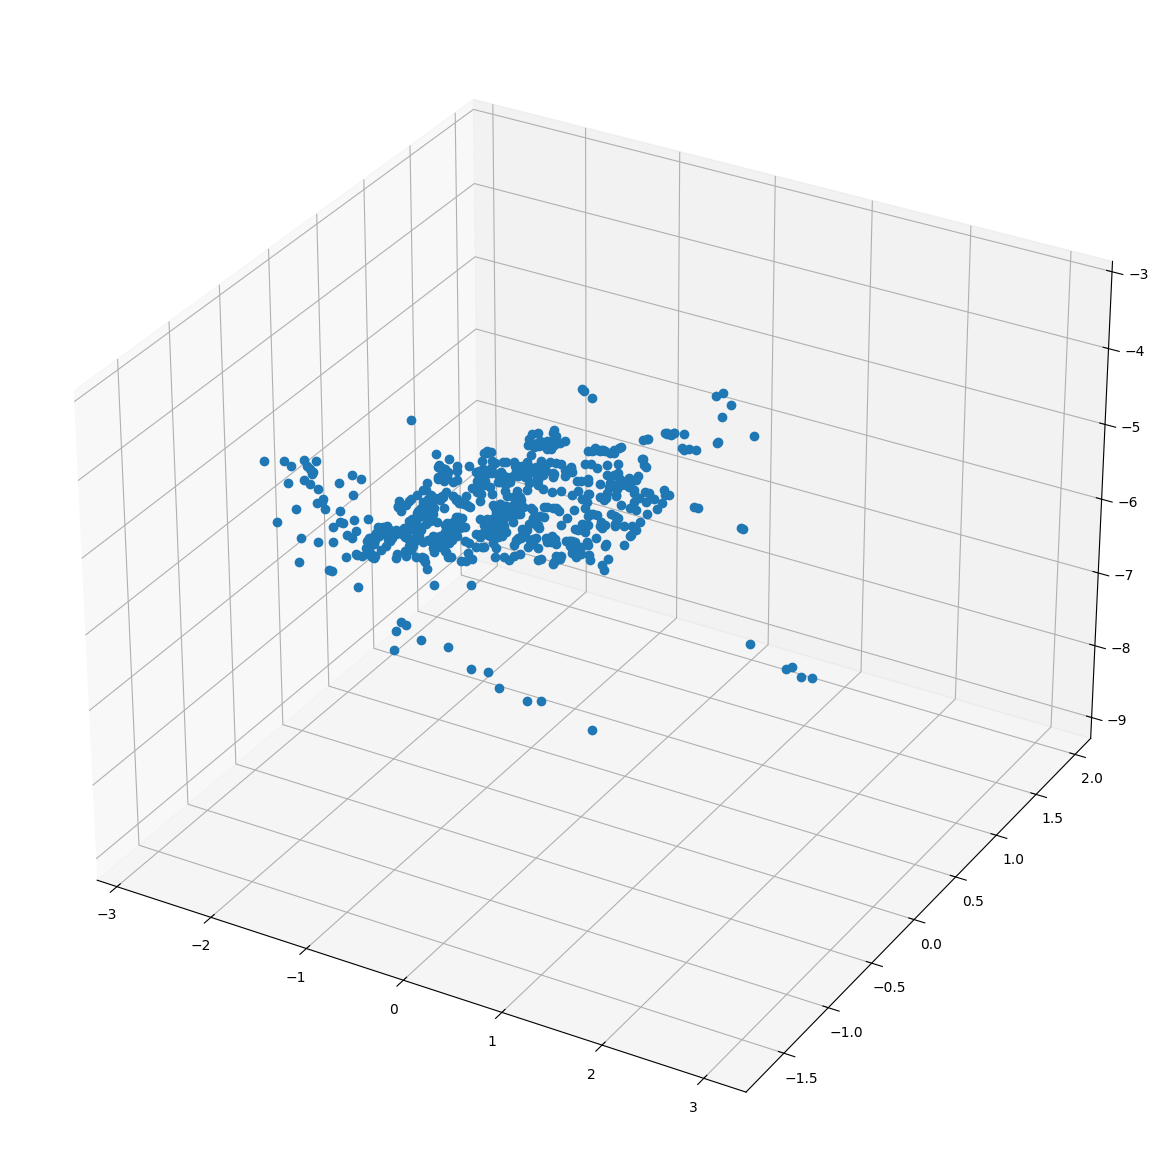

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize = [15,15])
ax = fig. add_subplot(projection = "3d")
ax.view_init(elev=None, azim=None) #you can set elevation/azimuth with different values
ax.plot(points_3D[0], points_3D[1], points_3D[2], 'o')
plt.draw()
plt.show()

In [7]:
# def project(P, X): #X is an array of 3D points
#  # Reshape X to be a column vector in homogeneous coordinates if it's a single point
#  if X.shape[0] == 3:
#   X = np.vstack((X, np.ones((1, X.shape[1] if X.ndim > 1 else 1))))

#  x = np.dot(P, X)
#  print(x)
#  for i in range(3): #convert to inhomogeneous coordinates
#   x[i] /= x[2]
#   print(x[i])
#  return x

# Y=project(P,np.array([[-1,-2,3]]).T) # Transpose to make it a column vector
# print(Y)

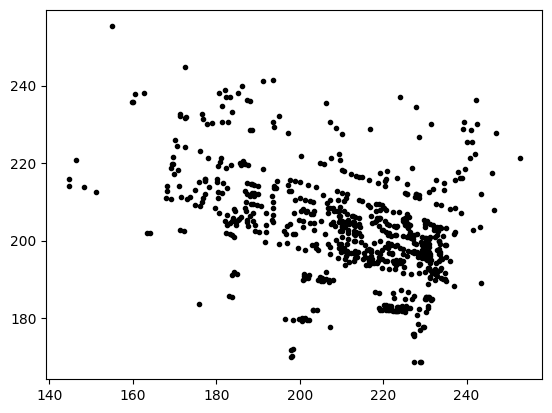

In [8]:
#projection
points_2D = project(P, points_3D)
#plot projection
from matplotlib import pyplot as plt
plt.plot(points_2D[0], points_2D[1], 'k.')
plt.show()

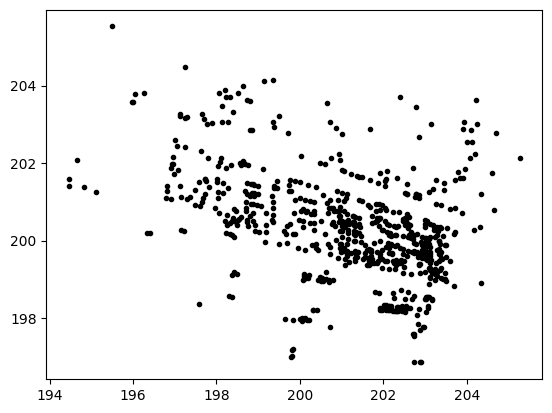

In [9]:
f2=10
K2 = np.array([[f2, 0, cx], [0, f2, cy], [0, 0, 1]])
P2 = np.dot(K2, np.hstack((I, t)))

#projection
points_2D_2 = project(P2, points_3D)
#plot projection
from matplotlib import pyplot as plt
plt.plot(points_2D_2[0], points_2D_2[1], 'k.')
plt.show()

with the change of F(focal length) the image scale is going to change, not the design of the image.

In [10]:
print(points_2D.shape)
print(points_3D.shape)

(3, 672)
(4, 672)


In [11]:
n_points = 6
points_3D_sampled = points_3D[:,:n_points]
points_2D_sampled = points_2D[:,:n_points]

In [12]:
A = np.zeros((2*n_points, 12), np.float32)
for i in range(n_points):
 A[2*i,:4] = points_3D_sampled[:,i].T
 A[2*i,8:12] = -points_2D_sampled[0,i] * points_3D_sampled[:,i].T
 A[2*i+1,4:8] = points_3D_sampled[:,i].T
 A[2*i+1,8:12] = -points_2D_sampled[1,i] * points_3D_sampled[:,i].T

In [13]:
from scipy import linalg
p = linalg.solve(A, np.zeros((12, 1), np.float32))
print(p)

[[-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]]


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06048e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [14]:
U, S, V = linalg.svd(A)

In [15]:
minS = np.min(S)
conditon = (S == minS)
minID = np.where(conditon)
print('index of the smallest singular value is: ', minID[0])

index of the smallest singular value is:  [11]


In [16]:
P_hat = V[minID[0],:].reshape(3, 4) / minS

In [17]:
print(P)
print(P_hat)

[[100.   0. 200.   0.]
 [  0. 100. 200.   0.]
 [  0.   0.   1.   0.]]
[[ 1.11691281e+05 -1.43983643e+02  2.22937000e+05 -9.67368958e+02]
 [ 1.07954132e+02  1.11449125e+05  2.22956797e+05 -8.77811462e+02]
 [ 5.45481384e-01 -6.31405234e-01  1.11480359e+03 -4.25531912e+00]]


In [18]:
x_P_hat = project(P_hat, points_3D_sampled[:, 0])
print(x_P_hat)

[225.25353617 181.44404194   1.        ]


In [19]:
x_P = points_2D_sampled[:,0]
print(x_P)

[225.25322768 181.44331296   1.        ]


In [20]:
x_P = points_2D
x_P_hat = project(P_hat, points_3D)
dist = 0
for i in range(x_P.shape[1]):
 dist += np.linalg.norm(x_P[:,i] - x_P_hat[:,i])
dist /= x_P.shape[1]
print(dist)

0.00267723816147505


In [21]:
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_total_points = points_3D.shape[1]
results = {}

for percentage in percentages:
    n_points = int(num_total_points * percentage)
    if n_points < 6: # Need at least 6 points to estimate the matrix
        print(f"Skipping {percentage*100}% because it results in less than 6 points.")
        continue

    # Sample n_points from the dataset
    # For simplicity, we'll just take the first n_points.
    # A more robust approach might involve random sampling.
    points_3D_sampled = points_3D[:, :n_points]
    points_2D_sampled = points_2D[:, :n_points]

    # Construct the matrix A
    A = np.zeros((2 * n_points, 12), np.float32)
    for i in range(n_points):
        A[2 * i, :4] = points_3D_sampled[:, i].T
        A[2 * i, 8:12] = -points_2D_sampled[0, i] * points_3D_sampled[:, i].T
        A[2 * i + 1, 4:8] = points_3D_sampled[:, i].T
        A[2 * i + 1, 8:12] = -points_2D_sampled[1, i] * points_3D_sampled[:, i].T

    # Estimate P_hat using SVD
    U, S, V = linalg.svd(A)
    # The last column of V corresponds to the smallest singular value
    P_hat = V[-1, :].reshape(3, 4)

    # Normalize P_hat (optional but good practice)
    # A common normalization is to make the last element of the matrix 1
    if P_hat[2,3] != 0:
        P_hat /= P_hat[2,3]
    else:
        # Handle the case where the last element is zero if necessary
        pass # Or normalize by a different element

    # Calculate the projection error (dist) using ALL points
    x_P = points_2D
    x_P_hat = project(P_hat, points_3D)

    dist = 0
    for i in range(x_P.shape[1]):
        dist += np.linalg.norm(x_P[:, i] - x_P_hat[:, i])
    dist /= x_P.shape[1]

    results[percentage] = dist

# Print the results
for percentage, error in results.items():
    print(f"Percentage of points: {percentage*100}%, Distance error: {error}")

# Find the percentage with the minimum error
min_percentage = min(results, key=results.get)
min_error = results[min_percentage]

print(f"\nBest percentage of points: {min_percentage*100}% with a distance error of: {min_error}")

Percentage of points: 10.0%, Distance error: 0.0009728377905776472
Percentage of points: 20.0%, Distance error: 0.0007639043769436937
Percentage of points: 30.0%, Distance error: 0.0006981142190187439
Percentage of points: 40.0%, Distance error: 0.0008188448789888815
Percentage of points: 50.0%, Distance error: 0.0003808028287266755
Percentage of points: 60.0%, Distance error: 0.002232575414992163
Percentage of points: 70.0%, Distance error: 0.0018850863765369757
Percentage of points: 80.0%, Distance error: 0.001540672277665282
Percentage of points: 90.0%, Distance error: 0.0011271374745679395
Percentage of points: 100.0%, Distance error: 0.0004900420954438563

Best percentage of points: 50.0% with a distance error of: 0.0003808028287266755


After running the code above, you can analyze the output to see how the distance error changes with the percentage of points used for estimation. The code will also tell you which percentage resulted in the minimum error.

In [22]:
import homography
import sfm
import ransac

Number of detected keypoints in img1: 971
Number of detected keypoints in img2: 983


(np.float64(-0.5), np.float64(959.5), np.float64(639.5), np.float64(-0.5))

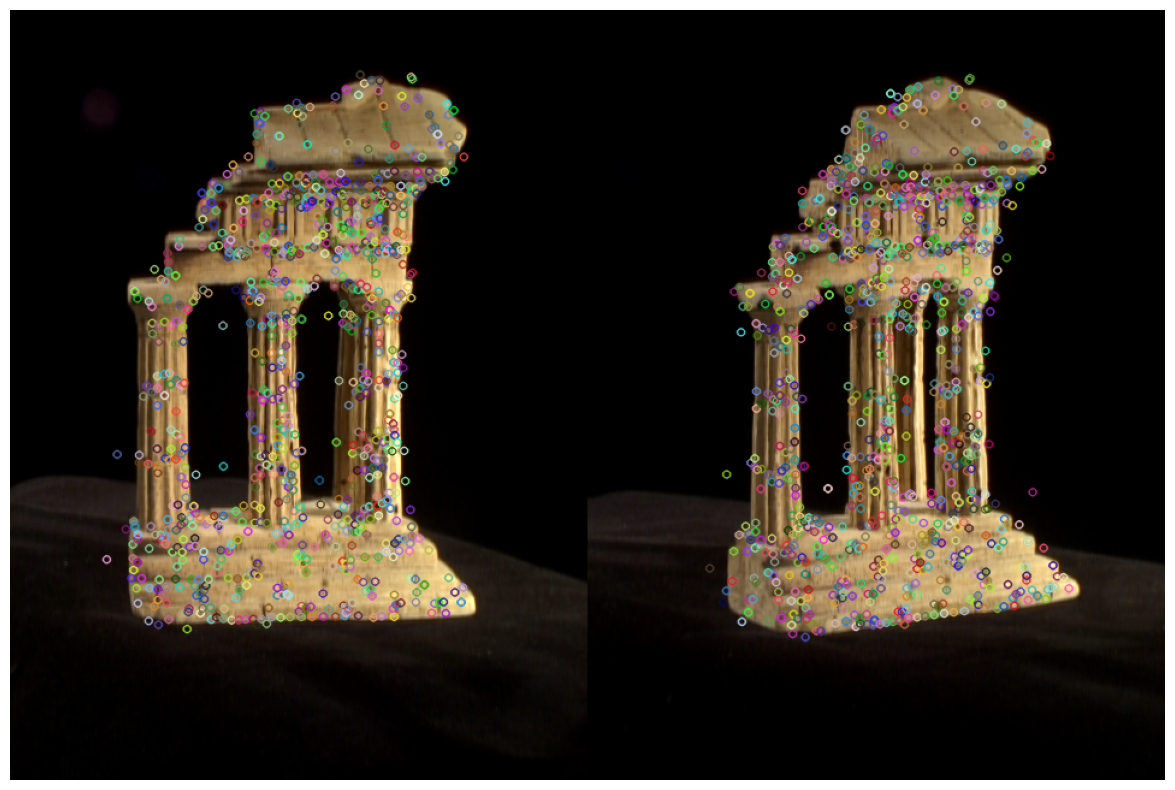

In [23]:
import cv2 as cv
sift = cv.SIFT_create()
img1 = cv.imread('temple2A.png')
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(img1_gray, None)
img2 = cv.imread('temple2B.png')
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
kp2, des2 = sift.detectAndCompute(img2_gray, None)
5
img1_kp = img1.copy()
img1_kp = cv.drawKeypoints(img1, kp1, img1_kp)
print("Number of detected keypoints in img1: %d" % (len(kp1)))
img2_kp = img2.copy()
img2_kp = cv.drawKeypoints(img2, kp2, img2_kp)
print("Number of detected keypoints in img2: %d" % (len(kp2)))
img1_2_kp = np.hstack((img1_kp, img2_kp))
plt.figure(figsize = (20, 10))
plt.imshow(img1_2_kp[:,:,::-1])
plt.axis('off')

In [24]:
bf = cv.BFMatcher(crossCheck = True) #crossCheck=True: find consistent matches
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
print("Number of consistent matches: %d" % len(matches))

Number of consistent matches: 483


(np.float64(-0.5), np.float64(959.5), np.float64(639.5), np.float64(-0.5))

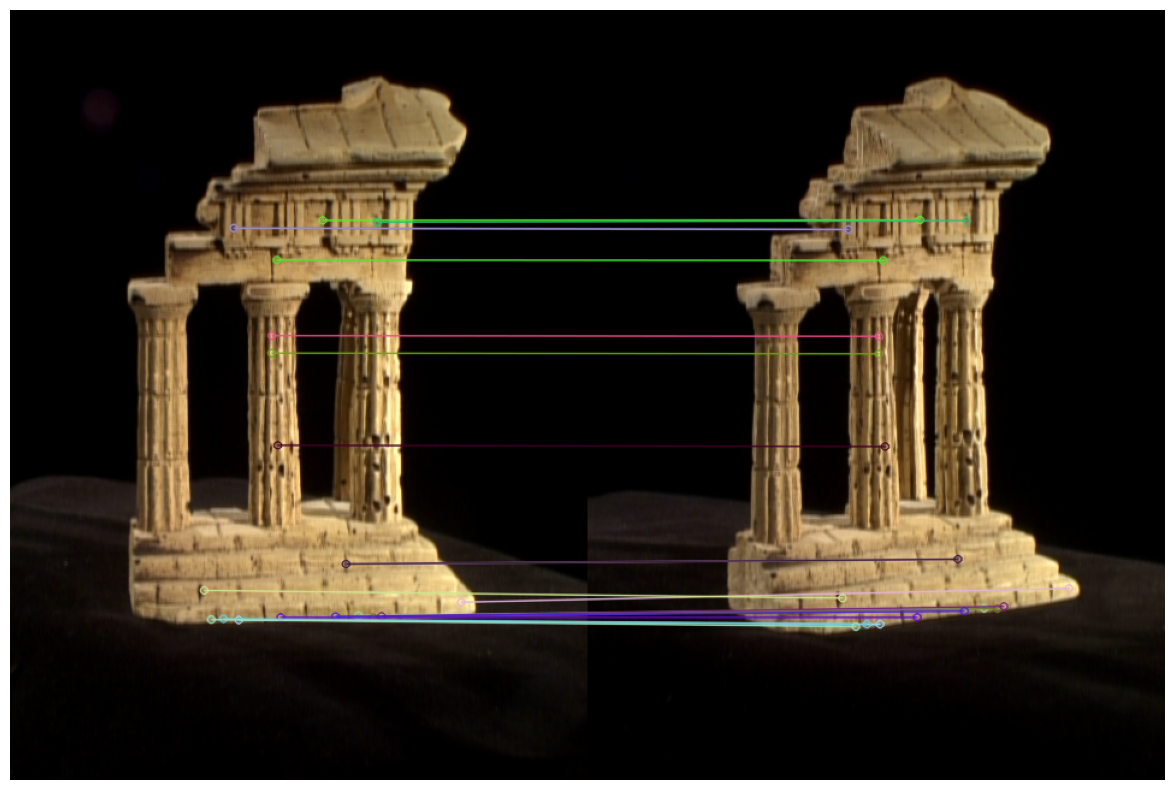

In [25]:
img1_2_matches = cv.drawMatches(img1, kp1, img2, kp2,
 matches[:20],
None,
flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20, 10))
plt.imshow(img1_2_matches[:,:,::-1])
plt.axis('off')

In [26]:
n_matches = min(len(matches), 1000)
kp1_array = np.zeros((2, n_matches), np.float32)
for i in range(n_matches):
 kp1_array[0][i] = kp1[matches[i].queryIdx].pt[0]
 kp1_array[1][i] = kp1[matches[i].queryIdx].pt[1]

kp2_array = np.zeros((2, n_matches), np.float32)
for i in range(n_matches):
 kp2_array[0][i] = kp2[matches[i].trainIdx].pt[0]
 kp2_array[1][i] = kp2[matches[i].trainIdx].pt[1]

In [27]:
x1 = homography.make_homog(kp1_array)
x2 = homography.make_homog(kp2_array)

In [28]:
K = np.array([[2394,0,932], [0,2398,628], [0,0,1]])
P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])

In [29]:
x1n = np.dot(linalg.inv(K), x1)
x2n = np.dot(linalg.inv(K), x2)

In [30]:
#estimate E with RANSAC
model = sfm.RansacModel()
E, inliers = sfm.F_from_ransac(x1n, x2n, model)

In [31]:
#compute camera matrices (P2 will be list of four solutions)
P2_all = sfm.compute_P_from_essential(E)
#pick the solution with points in front of cameras
ind = 0
maxres = 0
for i in range(4):
 #triangulate inliers and compute depth for each camera
 X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2_all[i])
 d1 = np.dot(P1, X)[2]
 d2 = np.dot(P2_all[i], X)[2]
 s = sum(d1 > 0) + sum(d2 > 0)
 if s > maxres:
  maxres = s
  ind = i
  infront = (d1 > 0) & (d2 > 0)
P2 = P2_all[ind]

In [32]:
#triangulate inliers and remove points not in front of both cameras
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2)
X = X[:, infront]

In [33]:
print(len(X[0]))

351


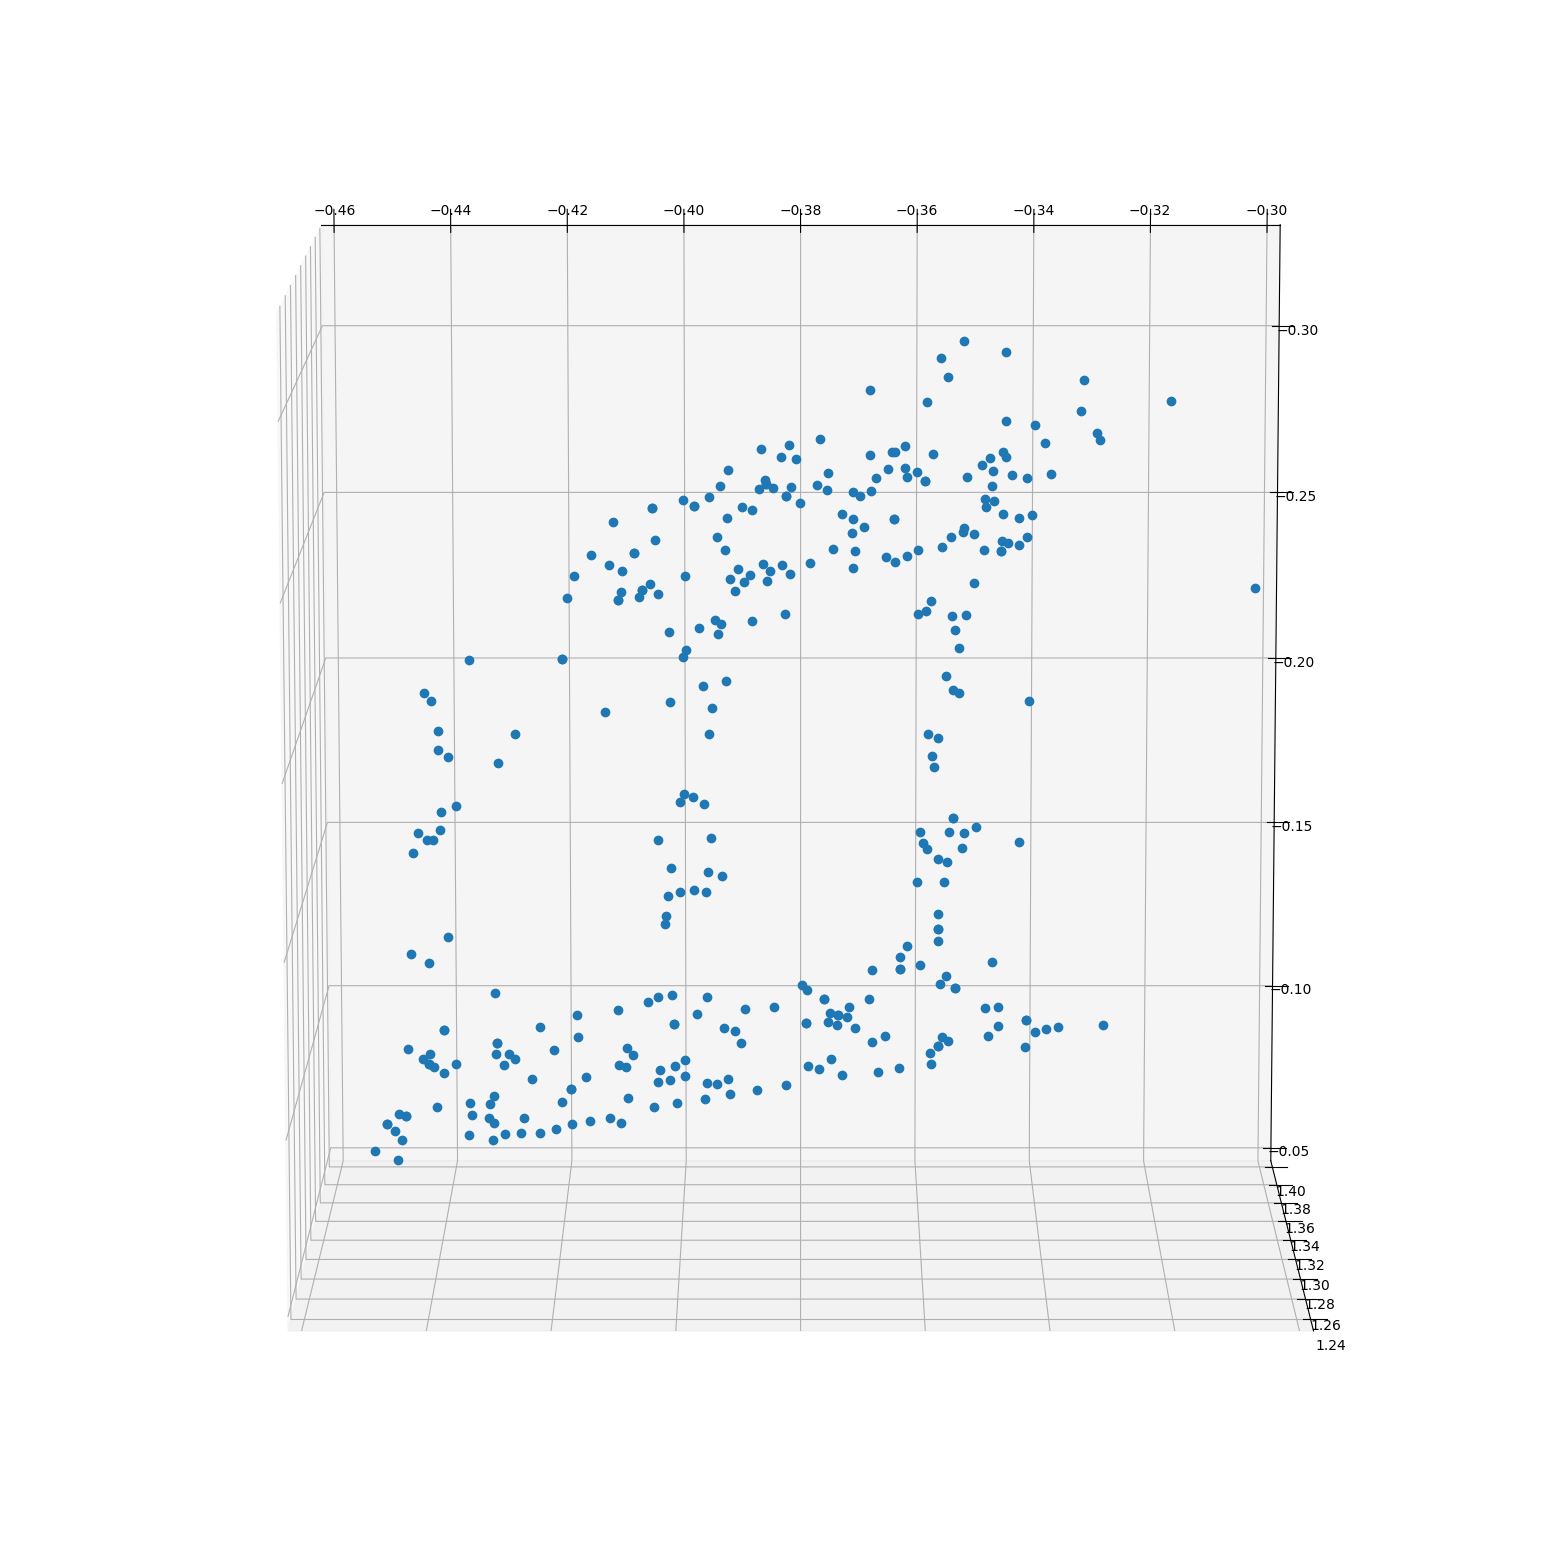

In [34]:
#3D plot
fig = plt.figure(figsize = [20,20])
ax = fig. add_subplot(projection = "3d")
ax.view_init(elev = -80, azim= -90)
ax.plot(X[0], X[1], X[2], 'o')
plt.draw()
plt.show()

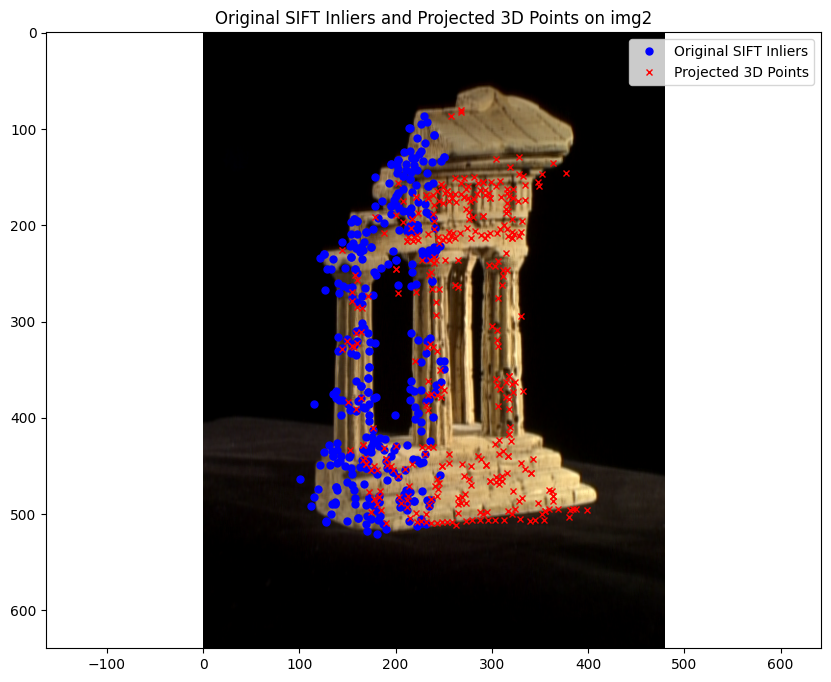

In [35]:
# Project the 3D points X onto img2 using P2
x_projected = project(P2, X)

# Convert projected points to image coordinates by multiplying with K
# The 'project' function already returns points in inhomogeneous coordinates,
# so we don't need to divide by the third component again, but we do
# need to scale and shift them according to the camera intrinsic matrix K.
# However, the 'project' function already handles the perspective division,
# so we just need to apply the intrinsic matrix K to get pixel coordinates.
# The 'project' function returns points in normalized image coordinates (scaled by depth).
# To get pixel coordinates, we need to multiply by K.
# Let's re-examine the 'project' function - it performs perspective division.
# So x_projected is already in the form (x/w, y/w, 1).
# To get pixel coordinates (u, v), we would typically do:
# u = K[0,0]*(x/w) + K[0,2]
# v = K[1,1]*(y/w) + K[1,2]
# Since x_projected[0] is x/w and x_projected[1] is y/w, and x_projected[2] is 1,
# we can get the pixel coordinates by multiplying with K:
x_image_coords = np.dot(K, x_projected)

# The points in x_image_coords are still in homogeneous coordinates with the third element as 1.
# We just need the first two rows for plotting as (u, v).
x_image_coords = x_image_coords[:2, :]


# Get the original SIFT keypoints from img2 that were used for triangulation (the inliers)
# We need to map the indices from the 'inliers' array back to the original kp2 list
original_keypoints_inliers = [kp2[i] for i in inliers]
original_points_img2 = np.array([[kp.pt[0], kp.pt[1]] for kp in original_keypoints_inliers]).T


# Plot img2
plt.figure(figsize=(10, 8))
plt.imshow(img2[:,:,::-1]) # Display in RGB

# Plot the original SIFT keypoints (inliers) on img2
plt.plot(original_points_img2[0, :], original_points_img2[1, :], 'bo', markersize=5, label='Original SIFT Inliers')

# Plot the projected 3D points on img2
plt.plot(x_image_coords[0, :], x_image_coords[1, :], 'rx', markersize=5, label='Projected 3D Points')

plt.title('Original SIFT Inliers and Projected 3D Points on img2')
plt.axis('equal') # Keep the aspect ratio equal
plt.legend()
plt.show()